In [348]:
import numpy as np
import pandas as pd
import pickle
import os
import cv2
import imageio
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import torch
import cmath
from sklearn.decomposition import PCA
from run_VAE import sites_NOVEMBER, RAW_NOVEMBER, INTERMEDIATE_NOVEMBER
from HiddenStateExtractor.cv2_feature import get_density, get_angle_apr, get_aspect_ratio_no_rotation
from HiddenStateExtractor.vq_vae import VQ_VAE, rescale
plt.switch_backend('module://ipykernel.pylab.backend_inline')

In [349]:
sites = sites_NOVEMBER
RAW_NOVEMBER = '/gpfs/CompMicro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/raw'
INTERMEDIATE_NOVEMBER = '/gpfs/CompMicro/Projects/learningCellState/microglia/raw_for_segmentation/NOVEMBER/supp'
wells = {'B4', 'B5', 'B2', 'C5', 'C4'}
wells_ = {'B4', 'B5', 'B2', 'C5'}
raw_folder = RAW_NOVEMBER
supp_folder = INTERMEDIATE_NOVEMBER

JUNE_sites = sum([['D%d-Site_%d' % (i, j) for j in range(9)] for i in range(3, 6)], [])
JUNE_DATA_PATH = '/gpfs/CompMicro/Projects/learningCellState/microglia/data_processed'

In [114]:
### Load All Data ###
dats = {}
fs = {}
traj_inds = {}
trajs = {}
traj_positions = {}
traj_mg_ratios = {}
for well in wells:
    path = os.path.join(raw_folder, '%s_latent_space_PCAed.pkl' % well)
    dats[well] = pickle.load(open(path, 'rb'))
    
    path = os.path.join(raw_folder, '%s_file_paths.pkl' % well)
    fs[well] = pickle.load(open(path, 'rb'))

    well_sites = [s for s in sites if s.startswith(well)]
    for site in well_sites:
        print(site)
        path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_traj.pkl')
        cell_trajectories_inds, cell_trajectories_positions = pickle.load(open(path, 'rb'))

        path = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'cell_pixel_assignments.pkl')
        cell_pixel_assignments = pickle.load(open(path, 'rb'))

        path = os.path.join(raw_folder, '%s_NNProbabilities.npy' % site)
        segmentation_stack = np.load(path)

        for i, (t, t_pos) in enumerate(zip(cell_trajectories_inds, cell_trajectories_positions)):
            ratios = []
            for t_point in t:
                cell_id = t[t_point]
                inds = np.where(cell_pixel_assignments[t_point][1] == cell_id)
                cell_pixels = cell_pixel_assignments[t_point][0][inds]
                cell_segmentation = segmentation_stack[t_point][(cell_pixels[:, 0], cell_pixels[:, 1])]
                mg_ratio = (cell_segmentation[:, 1] > 0.5).sum() / cell_segmentation.shape[0]
                ratios.append(mg_ratio)            

            trajs[site + '/%d' % i] = t
            traj_positions[site + '/%d' % i] = t_pos
            traj_mg_ratios[site + '/%d' % i] = ratios
    path = os.path.join(raw_folder, '%s_trajectories.pkl' % well)
    well_traj_inds = pickle.load(open(path, 'rb'))
    traj_inds.update({k: v for k, v in well_traj_inds.items() if k in trajs})

B2-Site_0
B2-Site_1
B2-Site_2
B2-Site_5
C5-Site_1
C5-Site_2
C5-Site_3
C5-Site_5
B4-Site_0
B4-Site_2
B4-Site_3
B4-Site_6
C4-Site_0
C4-Site_2
C4-Site_3
C4-Site_5
B5-Site_1
B5-Site_2
B5-Site_6
B5-Site_7


In [370]:
# with open('NOVEMBER_all_dat_save.pkl', 'wb') as f:
#     pickle.dump([dats, fs, traj_inds, trajs, traj_positions, traj_mg_ratios], f)
dats, fs, traj_inds, trajs, traj_positions, traj_mg_ratios = pickle.load(open('NOVEMBER_all_dat_save.pkl', 'rb'))

In [371]:
_trajs = {}
_traj_positions = {}
_traj_inds = {}
for t_name, ratios in traj_mg_ratios.items():
    well = t_name[:2]
    if not well in wells_: 
        continue
    assert len(ratios) == len(trajs[t_name])
    positions = np.stack(traj_positions[t_name].values(), 0)
    if np.percentile(positions[:, 0], 50) < 128 or np.percentile(positions[:, 0], 50) > (2048-128) or \
       np.percentile(positions[:, 1], 50) < 128 or np.percentile(positions[:, 1], 50) > (2048-128):
        continue
    if np.percentile(ratios, 30) < 0.7:
        for start in range(len(ratios)):
            if ratios[start] < 0.2:
                break
        for end in range(len(ratios)-1, 0, -1):
            if ratios[end] < 0.2:
                break
        
        if end - start < 10:
            continue
        if (end - start) < 50 and np.percentile(ratios[start:(end+1)], 60) > 0.5:
            continue
        
        t_points = sorted(trajs[t_name].keys())
        valid_t_points = t_points[start:(end+1)]
        _trajs[t_name] = {k: v for k,v in trajs[t_name].items() if k in valid_t_points}
        _traj_positions[t_name] = {k: v for k,v in traj_positions[t_name].items() if k in valid_t_points}
        _traj_inds[t_name] = traj_inds[t_name][start:(end+1)]
        assert len(_traj_inds[t_name]) == len(_trajs[t_name])

with open('NOVEMBER_dat_nonmg_save.pkl', 'wb') as f:
    pickle.dump([None, None, _traj_inds, _trajs, _traj_positions], f)

In [62]:
# site = 'B4-Site_0'
# image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
# for t in _trajs:
#     if t.startswith('B4-Site_0'):
#         stack = []
#         for frame_id in sorted(_trajs[t].keys()):
#             k = frame_id
#             mat = cv2.resize(image_stack[k, :, :, 0], (512, 512))
#             output_image = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')
#             output_image = np.stack([output_image] * 3, 2)
#             output_image = output_image / 65535.

#             box_center = traj_positions[t][k] / (2048/512)
#             box_range = [(max(box_center[0] - 16., 0), min(box_center[0] + 16., 512)),
#                          (max(box_center[1] - 16., 0), min(box_center[1] + 16., 512))]

#             # Left edge
#             x = box_range[0][0]
#             x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
#             output_image[x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
#             # Right edge
#             x = box_range[0][1]
#             x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
#             output_image[x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
#             # Top edge
#             y = box_range[1][0]
#             y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
#             output_image[int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
#             # Bottom edge
#             y = box_range[1][1]
#             y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
#             output_image[int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
#             stack.append(output_image)
#         stack = (np.stack(stack, 0)*255).astype('uint8')
#         imageio.mimwrite('nonmg_analysis/%s.gif' % t.replace('/', '_'), stack)

In [379]:
# Load NOVEMBER progenitor cell data
dats, fs, mg_traj_inds, mg_trajs, mg_traj_positions = pickle.load(open('NOVEMBER_dat_save.pkl', 'rb'))
_, _, traj_inds, trajs, traj_positions = pickle.load(open('NOVEMBER_dat_nonmg_save.pkl', 'rb'))

In [380]:
selected_ts = [t for t in traj_inds if len(traj_inds[t]) > 10]
traj_inds = {k:v for k,v in traj_inds.items() if k in selected_ts}
trajs = {k:v for k,v in trajs.items() if k in selected_ts}
traj_positions = {k:v for k,v in traj_positions.items() if k in selected_ts}

In [6]:
# Load JUNE progenitor cell data
june_dats_ = pickle.load(open('JUNE_nonmg_traj_dats_pcaed.pkl', 'rb'))
june_fs = pickle.load(open('JUNE_nonmg_traj_fs.pkl', 'rb'))
JUNE_progenitor_dats = pickle.load(open('JUNE_nonmg_traj_dats.pkl', 'rb'))

In [78]:
### Load All RAW Data ###
all_patches = {}
for well in wells:
    print(well)
    site_dat = torch.load(os.path.join(raw_folder, '%s_adjusted_static_patches.pt' % well))
    site_dat = rescale(site_dat)
    for i, f in enumerate(fs[well]):
        all_patches[f] = site_dat[i:(i+1)][0]

dats_full = {} 
for well in wells:
    path = os.path.join(raw_folder, '%s_latent_space.pkl' % well)
    dats_full[well] = pickle.load(open(path, 'rb'))

# june_patches = torch.load('JUNE_nonmg_trajs.pt')

B2
C5
B4
C4
B5


In [124]:
# # Load NOVEMBER+JUNE progenitor cell data (before PCA)
# progenitor_dats = []
# progenitor_names = []
# for t, inds in traj_inds.items():
#     well = t[:2]
#     for i in inds:
#         progenitor_dats.append(dats_full[well][i])
#         progenitor_names.append(fs[well][i])

In [364]:
# NOVEMBER_progenitor_dats = np.stack(progenitor_dats, 0)
# NOVEMBER_progenitor_names = progenitor_names
# pca = PCA(5)
# NOVEMBER_progenitor_dats_pcaed = pca.fit_transform(NOVEMBER_progenitor_dats)
# for pc in range(5):
#     for i in range(5):
#         inds = np.where((NOVEMBER_progenitor_dats_pcaed[:, pc] > np.percentile(NOVEMBER_progenitor_dats_pcaed[:, pc], i*20)) &
#                         (NOVEMBER_progenitor_dats_pcaed[:, pc] < np.percentile(NOVEMBER_progenitor_dats_pcaed[:, pc], (i+1)*20)))[0]
#         fs_of_interest = [NOVEMBER_progenitor_names[i] for i in inds]
#         patches_of_interest = [all_patches[f][0, 0] for f in fs_of_interest]
#         patch_averaged = np.stack(patches_of_interest, 0).mean(0)
#         plt.clf()
#         plt.imshow(patch_averaged, vmin=0.4, vmax=0.8)
#         plt.savefig("nonmg_analysis/NOVEMBER_PC%d_Q%d.png" % (pc+1, i), dpi=300)

In [ ]:
# NJ_progenitor_dats = np.concatenate([NOVEMBER_progenitor_dats, JUNE_progenitor_dats], 0)
# NJ_progenitor_names = NOVEMBER_progenitor_names + june_fs
# pca2 = PCA(5)
# NJ_progenitor_dats_pcaed = pca2.fit_transform(NJ_progenitor_dats)
# colors = [(1, 0, 0)] * len(NOVEMBER_progenitor_names) + [(0, 0, 1)] * len(june_fs)
# for pc in range(5):
#     for i in range(5):
#         inds = np.where((NJ_progenitor_dats_pcaed[:, pc] > np.percentile(NJ_progenitor_dats_pcaed[:, pc], i*20)) &
#                         (NJ_progenitor_dats_pcaed[:, pc] < np.percentile(NJ_progenitor_dats_pcaed[:, pc], (i+1)*20)))[0]
#         fs_of_interest = [NJ_progenitor_names[i] for i in inds]
#         patches_of_interest = [all_patches[f][0, 0] if isinstance(f, str) else 
#                                june_patches[june_fs.index(f)][0][0] for f in fs_of_interest]
#         patch_averaged = np.stack(patches_of_interest, 0).mean(0)
#         plt.clf()
#         plt.imshow(patch_averaged, vmin=0.4, vmax=0.8)
#         plt.savefig("nonmg_analysis/NJ_PC%d_Q%d.png" % (pc+1, i), dpi=300)

In [382]:
### Define Extra Functions ###
phase_a = 2.
phase_b = -50000.

legends = {
    'B2': 'GBM',
    'B4': 'IL17',
    'B5': 'IFN beta',
    'C4': 'Rubella',
    'C5': 'Control'
}

def hex_to_rgb(s):
    s = s.lstrip('#')
    s = list(int(s[i:i+2], 16)/256. for i in (0, 2, 4)) + [1.] # hex to rgb
    return s

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def generate_color_vectors(start, end, N=256):
    start = hex_to_rgb(start)
    end = hex_to_rgb(end)
    output = np.zeros((N, 4))
    for i in range(4):
        output[:, i] = np.linspace(start[i], end[i], N)
    return output

cmaps = {
    'B2': ListedColormap(generate_color_vectors('#ffffff', '#438548')),
    'B4': ListedColormap(generate_color_vectors('#ffffff', '#ce103d')),
    'B5': ListedColormap(generate_color_vectors('#ffffff', '#d44d00')),
    'C4': ListedColormap(generate_color_vectors('#ffffff', '#f0ba00')),
    'C5': ListedColormap(generate_color_vectors('#ffffff', '#005082')),
    'all': ListedColormap(generate_color_vectors('#ffffff', '#111111'))
}

colors = {w: cmaps[w](0.8) for w in cmaps}

def enhance_contrast(mat, a=1.5, b=-10000):
  mat2 = cv2.addWeighted(mat, a, mat, 0, b)
  return mat2

def save_movie(traj, path):
  well = traj[:2]
  site = traj.split('/')[0]
  stacks = []
  for ind in traj_inds[traj]:
    f = fs[well][ind]
    p = os.path.join(supp_folder, '%s-supps' % well, '%s' % site, 'stacks_%s.pkl' % f.split('/')[-1].split('_')[0])
    mat = pickle.load(open(p, 'rb'))[f]['mat'][:, :, 0]
    mat2 = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')
    stacks.append(mat2)
  output = (np.stack(stacks, 0).astype('float')/256).astype('uint8')
  imageio.mimsave(path, output)

def save_traj_bbox(traj, path):
  output_images = np.zeros((len(traj_inds[traj]), 512, 512))
  site = traj.split('/')[0]
  image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
  for i, k in enumerate(sorted(trajs[traj].keys())):
    mat = cv2.resize(image_stack[k, :, :, 0], (512, 512))
    output_images[i] = np.clip(enhance_contrast(mat, phase_a, phase_b), 0, 65535).astype('uint16')

  output_images = np.stack([output_images] * 3, 3)
  output_images = output_images / 65535.

  for i, k in enumerate(sorted(trajs[traj].keys())):
    box_center = traj_positions[traj][k] / (2048/512)
    box_range = [(max(box_center[0] - 16., 0), min(box_center[0] + 16., 512)),
                 (max(box_center[1] - 16., 0), min(box_center[1] + 16., 512))]
    
    # Left edge
    x = box_range[0][0]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Right edge
    x = box_range[0][1]
    x_ = (int(max(x - 1., 0)), int(min(x + 1., 512)))
    output_images[i, x_[0]:x_[1], int(box_range[1][0]):int(box_range[1][1])] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Top edge
    y = box_range[1][0]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
    # Bottom edge
    y = box_range[1][1]
    y_ = (int(max(y - 1., 0)), int(min(y + 1., 512)))
    output_images[i, int(box_range[0][0]):int(box_range[0][1]), y_[0]:y_[1]] = np.array([1., 0., 0.]).reshape((1, 1, 3))
  # tifffile.imwrite(path, (output_images*255).astype('uint8'))
  imageio.mimwrite(path, (output_images*255).astype('uint8'))
  return

In [383]:
### Process Data and Generate Trajectory Summaries ###
t_lag = 1
bins_PC1 = np.linspace(-4, 6, 15)
bins_PC2 = np.linspace(-3, 8, 15)
bins_speed = np.linspace(1.0, 5.2, 15) # Log um/h scale

traj_PC1 = {well: [] for well in wells}
traj_PC2 = {well: [] for well in wells}
traj_speed = {well: [] for well in wells}
traj_names = {well: [] for well in wells}
for t in trajs:
    well = t[:2]
    if not well in wells:
        continue 
    traj_names[well].append(t)
    traj_PC1[well].append(np.mean([dats[well][ind, 0] for ind in traj_inds[t]]))
    traj_PC2[well].append(np.mean([dats[well][ind, 1] for ind in traj_inds[t]]))

    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)    
    traj_speed[well].append(np.log(np.mean(dists) * 0.325 / 0.1518)) # Unit of pixel(0.325um) per frame(9.11 min) to um per hour

In [9]:
### Trajectory averaged PC1, PC2, speed for JUNE data progenitor cells ###
traj_PC1_june = {}
traj_PC2_june = {}
for f, d in zip(june_fs, june_dats_):
    if not f[0] in traj_PC1_june:
        traj_PC1_june[f[0]] = []
        traj_PC2_june[f[0]] = []
    traj_PC1_june[f[0]].append(d[0])
    traj_PC2_june[f[0]].append(d[1])

traj_PC1_june = [np.mean(traj_PC1_june[k]) for k in traj_PC1_june]
traj_PC2_june = [np.mean(traj_PC2_june[k]) for k in traj_PC2_june]

traj_motions_june = {}
for site in sum([['D%d-Site_%d' % (i, j) for j in range(9)] for i in range(3, 6)], []): 
    nonmg_traj = pickle.load(open(os.path.join(JUNE_DATA_PATH, 'D-supps', site, 'non_mg_traj.pkl'), 'rb'))
    for i, (traj, traj_position) in enumerate(zip(*nonmg_traj)):
        name = site + '/' + str(i) + '_nonmg'
        traj_motions_june[name] = traj_position
        
traj_speed_june = {}
t_lag = 1
for t, motion in traj_motions_june.items():
    dists = []
    t_keys = sorted(motion.keys())
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(motion[t_point+t_lag] - \
                               motion[t_point], ord=2)
            dists.append(d)    
    traj_speed_june[t] = np.log(np.mean(dists) * 0.325 / 0.1518)

In [ ]:
os.system('zip nonmg_trajs.zip nonmg_analysis/sample*gif')

In [397]:
np.random.seed(123)
for t in trajs:
    print(t)
    save_traj_bbox(t, 'nonmg_analysis/sample_%s.gif' % t.replace('/', '_'))

B2-Site_0/3
B2-Site_0/18
B2-Site_0/62
B2-Site_1/20
B2-Site_1/27
B2-Site_1/36
B2-Site_1/68
B2-Site_1/93
B2-Site_1/94
B2-Site_1/99
B2-Site_1/111
B2-Site_1/155
B2-Site_1/159
B2-Site_1/170
B2-Site_1/178
B2-Site_1/199
B2-Site_1/205
B2-Site_1/217
B2-Site_1/236
B2-Site_1/250
B2-Site_1/259
B2-Site_1/277
B2-Site_2/37
B2-Site_2/38
B2-Site_2/72
B2-Site_2/237
B2-Site_2/316
B2-Site_5/28
B2-Site_5/74
B2-Site_5/103
B2-Site_5/111
B2-Site_5/119
B2-Site_5/138
B2-Site_5/167
B2-Site_5/215
B2-Site_5/270
B2-Site_5/309
C5-Site_1/34
C5-Site_1/84
C5-Site_1/103
C5-Site_1/120
C5-Site_1/165
C5-Site_1/199
C5-Site_1/209
C5-Site_1/250
C5-Site_1/263
C5-Site_1/457
C5-Site_1/468
C5-Site_1/516
C5-Site_2/42
C5-Site_2/83
C5-Site_2/87
C5-Site_2/88
C5-Site_2/92
C5-Site_2/142
C5-Site_2/161
C5-Site_2/180
C5-Site_2/237
C5-Site_3/53
C5-Site_3/117
C5-Site_3/261
C5-Site_3/367
C5-Site_3/383
C5-Site_5/62
C5-Site_5/101
C5-Site_5/152
C5-Site_5/279
C5-Site_5/427
B4-Site_0/16
B4-Site_0/59
B4-Site_0/61
B4-Site_0/63
B4-Site_0/83
B4-Site_

In [375]:
### Sample trajectories with traj marked ###
traj_represented = ['B4-Site_0/63',
                    'B4-Site_3/50']
cs = [(20, 20, 20)] * 2

for t, c in zip(traj_represented, cs):
    well = t[:2]
    traj = traj_inds[t]
    
    site = t.split('/')[0]
    image_stack = np.load(os.path.join(raw_folder, '%s.npy' % site))
    
    t_pos = traj_positions[t]
    
    init_t_point = sorted(t_pos.keys())[28]
    init_position = t_pos[init_t_point]
    if init_position[0] < 256 or init_position[0] > (2048-256) or init_position[1] < 256 or init_position[1] > (2048-256):
        continue

    f0 = image_stack[init_t_point, 
                     (init_position[0]-256):(init_position[0]+256),
                     (init_position[1]-256):(init_position[1]+256),
                     0]
    
    f0 = enhance_contrast(f0, phase_a, phase_b)
    mat = np.zeros((f0.shape[0], f0.shape[1], 3), dtype='uint8')
    mat[:, :] = (np.expand_dims(f0, 2) / 256).astype('uint8')
    try:
        t_pos = traj_positions[t]
        positions = np.stack([t_pos[k] for k in sorted(t_pos.keys())])
        center_position = positions[init_t_point] - np.array([256, 256])
        for i in range(positions.shape[0] - 1):
            start = positions[i] - center_position
            end = positions[i + 1] - center_position
            mat = cv2.line(mat, (start[1], start[0]), (end[1], end[0]), c, thickness=2)
        cv2.imwrite('nonmg_analysis/NOVEMBER_nonmg_sample_%s.png' % t.replace('/', '_'), mat)
    except Exception as e:
        print(e)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

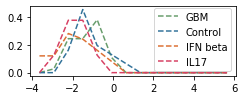

In [384]:
plt.clf()
f = plt.figure(figsize=(3.5, 1.5))
for well in wells_:
    freqs, bins = np.histogram(traj_PC1[well], bins=bins_PC1)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, '--', c=colors[well], label=legends[well]) 
    
# freqs, bins = np.histogram(traj_PC1_june, bins=bins_PC1)
# freqs = freqs/freqs.sum()
# x = (bins[:-1] + bins[1:])/2
# plt.plot(x, freqs, c='k', label='June batch')

plt.xlabel("")
plt.ylabel("")
plt.legend()
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_PC1.eps')
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_PC1.png', dpi=300)


<Figure size 432x288 with 0 Axes>

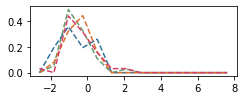

In [385]:
plt.clf()
f = plt.figure(figsize=(3.5, 1.5))
for well in wells_:
    freqs, bins = np.histogram(traj_PC2[well], bins=bins_PC2)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, '--', c=colors[well], label=legends[well])

# freqs, bins = np.histogram(traj_PC2_june, bins=bins_PC2)
# freqs = freqs/freqs.sum()
# x = (bins[:-1] + bins[1:])/2
# plt.plot(x, freqs, c='k', label='June batch')

plt.xlabel("")
plt.ylabel("")
plt.grid(b=False, which='major', axis='x')
plt.tight_layout()
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_PC2.eps')
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_PC2.png', dpi=300)


<Figure size 432x288 with 0 Axes>

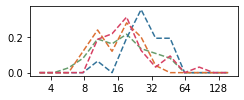

In [386]:
plt.clf()
f = plt.figure(figsize=(3.5, 1.5))
for well in wells_:
    freqs, bins = np.histogram(traj_speed[well], bins=bins_speed)
    freqs = freqs/freqs.sum()
    x = (bins[:-1] + bins[1:])/2
    plt.plot(x, freqs, '--', c=colors[well], label=legends[well])

# freqs, bins = np.histogram(list(traj_speed_june.values()), bins=bins_speed)
# freqs = freqs/freqs.sum()
# x = (bins[:-1] + bins[1:])/2
# plt.plot(x, freqs, c='k', label='June batch')

plt.xlabel("")
plt.ylabel("")
plt.grid(b=False, which='major', axis='x')
speed_ticks = [4, 8, 16, 32, 64, 128]
plt.gca().set_xticks(np.log(speed_ticks))
plt.gca().set_xticklabels(speed_ticks)
plt.tight_layout()
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_speed.eps')
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_speed.png', dpi=300)

In [387]:
### GMM to multiple states ###
t_lag = 1
mg_traj_properties = {}
X = []
Y = []
mg_t_arrays = []
for t in mg_trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_keys = sorted(mg_trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(mg_traj_positions[t][t_point+t_lag] - \
                               mg_traj_positions[t][t_point], ord=2)
            dists.append(d)
        
    mg_traj_PC = [dats[well][ind] for ind in mg_traj_inds[t]]
    mg_traj_dist = dists
    mg_traj_properties[t] = (mg_traj_PC, mg_traj_dist)
    X.append(np.concatenate([np.array(np.log(np.mean(mg_traj_dist) * 0.325 / 0.1518)).reshape((-1,)), np.mean(mg_traj_PC, 0)]))
    Y.append(sorted(wells_).index(well))
    mg_t_arrays.append(t)
    
mg_X = np.array(X)
mg_Y = np.array(Y)
std_unit = np.std(X, 0)
std_unit = np.clip(std_unit, 0.6, 10.)
# std_unit[1:] = np.clip(std_unit[1:], std_unit[1], 10.)

In [388]:
### GMM ###
def calculate_sample_prob_mat(X, centers, stds):
    # Sample prob mat should be N * 2
    n_feat = X.shape[1]
    X_ = X.reshape((-1, 1, n_feat))
    centers_ = np.array(centers).reshape((1, -1, n_feat))
    stds_ = np.array(stds).reshape((1, -1, n_feat))
    prob_mat = np.square((X_ - centers_)/stds_).sum(2)
    prob_mat = prob_mat - prob_mat.min(1, keepdims=True)
    prob_mat = np.exp(-0.5 * prob_mat)
    return prob_mat


def initialize_well_prob_mat(sample_prob_mat, y):
    # Well prob mat should be 5*2
    classes = sorted(np.unique(y))
    prob_mat = np.zeros((len(classes), sample_prob_mat.shape[1]))
    for i, c in enumerate(classes):
        line = sample_prob_mat[np.where(y == c)].sum(0)
        line = line/line.sum()
        prob_mat[i] = line
    return prob_mat


def get_merged_prob_mat(X, y, centers, stds, well_prob_mat):
    # E-step
    sample_prob_mat = calculate_sample_prob_mat(X, centers, stds)
    prob_mat = []
    for i in range(len(X)):
        prob_ = sample_prob_mat[i] * well_prob_mat[y[i]]
        prob_ = prob_/prob_.sum()
        prob_mat.append(prob_)
    prob_mat = np.stack(prob_mat, 0)
    return prob_mat
    

def calculate_new_centers(X, y, prob_mat):
    # M-step
    classes = sorted(np.unique(y))
    weights = prob_mat

    outlying = np.zeros((X.shape[0],))
    for i, c in enumerate(classes):
        inds = np.where(y == c)
        X_c = X[inds]
        median_X_c = np.median(X_c, keepdims=True, axis=0)
        outlying[inds] = np.linalg.norm(X_c - median_X_c, axis=1, ord=2)  
  
    outlying = (1 - 0.7 * (outlying - outlying.min())/(outlying.max() - outlying.min())) ** 10.
    weights = weights * outlying.reshape((-1, 1))
  
    centers = []
    stds = []
    for i in range(weights.shape[1]):
        w = weights[:, i:(i+1)]
        center = (w * X).sum(0)/w.sum()
        centers.append(center)
        std = np.sqrt(((w * (X - center) ** 2).sum(0)/w.sum()))
        ratio = np.median((std/std_unit)[:5])
        stds.append(ratio * std_unit)

    well_prob_mat = []
    for i, c in enumerate(classes):
        inds = np.where(y == c)
        well_prob_mat.append(weights[inds].sum(0)/weights[inds].sum())
    well_prob_mat = np.stack(well_prob_mat, 0)
    return centers, stds, well_prob_mat
  
    
# Two states or three states
init_center1 = np.median(mg_X[np.where(mg_Y == 1)], 0)
init_center2 = np.median(mg_X[np.where(mg_Y == 3)], 0)
init_center1 += np.random.normal(0, 0.1, init_center1.shape)
init_center2 += np.random.normal(0, 0.1, init_center1.shape)
centers = [init_center1, init_center2]
stds = [0.6*std_unit for c in centers]
well_prob_mat = initialize_well_prob_mat(calculate_sample_prob_mat(mg_X, centers, stds), mg_Y)

for i in range(20): 
    prob_mat = get_merged_prob_mat(mg_X, mg_Y, centers, stds, well_prob_mat)
    centers, _, well_prob_mat = calculate_new_centers(mg_X, mg_Y, prob_mat)
print(well_prob_mat)

### Calculate trajectory states ###
state_cmaps = [plt.get_cmap(name) for name in ['Blues', 'Reds', 'Greens', 'Oranges']]
traj_states = {well: [] for well in wells_}
prob_mat = get_merged_prob_mat(mg_X, mg_Y, centers, stds, well_prob_mat)

[[0.37813517 0.62186483]
 [0.90453931 0.09546069]
 [0.98587285 0.01412715]
 [0.13004223 0.86995777]]


In [389]:
### Non-MG cell properties ###
t_lag = 1
nonmg_traj_properties = {}
X = []
Y = []
t_arrays = []
for t in trajs:
    well = t[:2]
    if not well in wells_:
        continue
    t_keys = sorted(trajs[t].keys())
    dists = []
    for t_point in t_keys:
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            dists.append(d)
        
    traj_PC = [dats[well][ind] for ind in traj_inds[t]]
    traj_dist = dists
    nonmg_traj_properties[t] = (traj_PC, traj_dist)
    X.append(np.concatenate([np.array(np.log(np.mean(traj_dist) * 0.325 / 0.1518)).reshape((-1,)), np.mean(traj_PC, 0)]))
    Y.append(sorted(wells_).index(well))
    t_arrays.append(t)

X = np.array(X)
Y = np.array(Y)

In [390]:
### Calculate Cell Motion Directions ###

cell_aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))
traj_orientations = {}
traj_orientations2 = {}
traj_orientation_stds = {}
patch_orientations = {}
patch_displacements = {}
t_lag = 1

angs1_all = []
angs2_all = []
ang_diffs_all = []
for t in traj_inds:
    well = t[:2]
    traj_fs = [fs[well][ind] for ind in traj_inds[t]]
    t_keys = sorted(trajs[t].keys())
    
    valid_fs = []
    ds = []
    d_angs = []
    for i, f in enumerate(traj_fs):
        t_point = t_keys[i]
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(traj_positions[t][t_point+t_lag] - \
                               traj_positions[t][t_point], ord=2)
            d_ang = traj_positions[t][t_point+t_lag] - traj_positions[t][t_point]
            d_ang = cmath.polar(complex(d_ang[1], d_ang[0]))[1]
            valid_fs.append(f)
            ds.append(d)
            d_angs.append(d_ang)

    traj_cell_aps = [cell_aps[f][0] for f in valid_fs]
    traj_cell_angs = [cell_aps[f][1] for f in valid_fs]

    angs1 = [a for i, a in enumerate(d_angs) if traj_cell_aps[i] > 1.1] # Orientation of movement, 0 ~ 2pi
    angs2 = [a for i, a in enumerate(traj_cell_angs) if traj_cell_aps[i] > 1.1]
    angs2 = [a if a > 0 else a + np.pi for a in angs2] # Orientation of cell long axis, 0~pi
    angs1_all.extend(angs1)
    angs2_all.extend(angs2)
    ds = [d for i, d in enumerate(ds) if traj_cell_aps[i] > 1.1]
    valid_fs_ = [f for i, f in enumerate(valid_fs) if traj_cell_aps[i] > 1.1]
    if len(angs1) <= 2:
        continue
    
    ang_diffs = [(a1 - a2)%(np.pi) for a1, a2 in zip(angs1, angs2)]
    #ang_diffs = [a if a < np.pi/2 else a - np.pi for a in ang_diffs]
    ang_diffs_all.extend(ang_diffs)
    for f, a in zip(valid_fs_, ang_diffs):
        patch_orientations[f] = a
    for f, d in zip(valid_fs_, ds):
        patch_displacements[f] = d
    
    # Pool angles along the traj
    merged_x = sum([d * np.cos(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_y = sum([d * np.sin(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_d, merged_ang_diff = cmath.polar(complex(merged_x, merged_y))
    
    assert np.allclose(merged_d, np.sqrt(merged_x**2 + merged_y**2))
    traj_orientations[t] = merged_ang_diff / 2
    traj_orientations2[t] = np.arctan(merged_y/merged_x) / 2
    traj_orientation_stds[t] = merged_d/sum(ds)


In [391]:
### Calculate Cell Motion Directions ###

cell_aps = pickle.load(open(os.path.join(raw_folder, 'all_patches_cell_aspect_ratios.pkl'), 'rb'))
mg_traj_orientations = {}
mg_traj_orientations2 = {}
mg_traj_orientation_stds = {}
patch_orientations = {}
patch_displacements = {}
t_lag = 1

angs1_all = []
angs2_all = []
ang_diffs_all = []
for t in mg_traj_inds:
    well = t[:2]
    mg_traj_fs = [fs[well][ind] for ind in mg_traj_inds[t]]
    t_keys = sorted(mg_trajs[t].keys())
    
    valid_fs = []
    ds = []
    d_angs = []
    for i, f in enumerate(mg_traj_fs):
        t_point = t_keys[i]
        if (t_point + t_lag) in t_keys:
            d = np.linalg.norm(mg_traj_positions[t][t_point+t_lag] - \
                               mg_traj_positions[t][t_point], ord=2)
            d_ang = mg_traj_positions[t][t_point+t_lag] - mg_traj_positions[t][t_point]
            d_ang = cmath.polar(complex(d_ang[1], d_ang[0]))[1]
            valid_fs.append(f)
            ds.append(d)
            d_angs.append(d_ang)

    mg_traj_cell_aps = [cell_aps[f][0] for f in valid_fs]
    mg_traj_cell_angs = [cell_aps[f][1] for f in valid_fs]

    angs1 = [a for i, a in enumerate(d_angs) if mg_traj_cell_aps[i] > 1.1] # Orientation of movement, 0 ~ 2pi
    angs2 = [a for i, a in enumerate(mg_traj_cell_angs) if mg_traj_cell_aps[i] > 1.1]
    angs2 = [a if a > 0 else a + np.pi for a in angs2] # Orientation of cell long axis, 0~pi
    angs1_all.extend(angs1)
    angs2_all.extend(angs2)
    ds = [d for i, d in enumerate(ds) if mg_traj_cell_aps[i] > 1.1]
    valid_fs_ = [f for i, f in enumerate(valid_fs) if mg_traj_cell_aps[i] > 1.1]
    if len(angs1) <= 2:
        continue
    
    ang_diffs = [(a1 - a2)%(np.pi) for a1, a2 in zip(angs1, angs2)]
    #ang_diffs = [a if a < np.pi/2 else a - np.pi for a in ang_diffs]
    ang_diffs_all.extend(ang_diffs)
    for f, a in zip(valid_fs_, ang_diffs):
        patch_orientations[f] = a
    for f, d in zip(valid_fs_, ds):
        patch_displacements[f] = d
    
    # Pool angles along the traj
    merged_x = sum([d * np.cos(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_y = sum([d * np.sin(2 * ang) for d, ang in zip(ds, ang_diffs)])
    merged_d, merged_ang_diff = cmath.polar(complex(merged_x, merged_y))
    
    assert np.allclose(merged_d, np.sqrt(merged_x**2 + merged_y**2))
    mg_traj_orientations[t] = merged_ang_diff / 2
    mg_traj_orientations2[t] = np.arctan(merged_y/merged_x) / 2
    mg_traj_orientation_stds[t] = merged_d/sum(ds)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

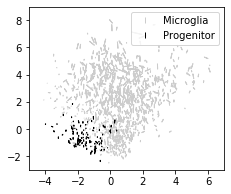

In [392]:
speed_ticks = [4., 8., 16., 32., 64., 128.]

plt.clf()
f = plt.figure(figsize=(3.5, 3))
np.random.seed(128)
random_selected_inds = np.random.choice(np.arange(len(mg_X)), (1000,), replace=False)
for i in random_selected_inds:
    t = mg_t_arrays[i]
    merged_ang_diff = mg_traj_orientations[t]
    merged_d = np.exp(mg_X[i, 0])/200
    #merged_d = (1 - traj_orientation_stds[t])/2 # Longer marker indicates more consistent movement (smaller circular SD)
    arrow_vec = (merged_d * np.sin(merged_ang_diff), merged_d * np.cos(merged_ang_diff))
    x_center = mg_X[i, 1]
    y_center = mg_X[i, 2]
    dx = arrow_vec[0]
    dy = arrow_vec[1]
    x = x_center - dx/2
    y = y_center - dy/2
    plt.arrow(x, y, dx, dy, color=(0.8, 0.8, 0.8), width=0.001, head_width=0.)

random_selected_inds = np.random.choice(np.arange(len(X)), (100,), replace=False)
for i in random_selected_inds:
    t = t_arrays[i]
    if not t in traj_orientations:
        continue
    merged_ang_diff = traj_orientations[t]
    merged_d = np.exp(X[i, 0])/200
    #merged_d = (1 - traj_orientation_stds[t])/2 # Longer marker indicates more consistent movement (smaller circular SD)
    arrow_vec = (merged_d * np.sin(merged_ang_diff), merged_d * np.cos(merged_ang_diff))
    x_center = X[i, 1]
    y_center = X[i, 2]
    dx = arrow_vec[0]
    dy = arrow_vec[1]
    x = x_center - dx/2
    y = y_center - dy/2
    plt.arrow(x, y, dx, dy, color=(0., 0., 0.), width=0.01, head_width=0.)

plt.xlabel("")
plt.ylabel("")
plt.xlim(-5, 7)
plt.ylim(-3, 9)

import matplotlib.patches as mpatches
plt.plot([-10], [-1], '|', color=(0.8, 0.8, 0.8), label='Microglia')
plt.plot([-10], [-1], '|', color=(0., 0., 0.), label='Progenitor')
plt.legend()

plt.savefig('nonmg_analysis/NOVEMBER_mg_nonmg_PC12.eps')
plt.savefig('nonmg_analysis/NOVEMBER_mg_nonmg_PC12.png', dpi=300)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<Figure size 432x288 with 0 Axes>

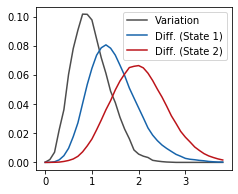

In [393]:
n_feat = 5
stds_ = np.ones((1, 49))
dist_within = np.linalg.norm((X/stds_)[:, :n_feat].reshape((-1, 1, n_feat)) - \
                             (X/stds_)[:, :n_feat].reshape((1, -1, n_feat)), axis=2, ord=2)

dist_to_g1 = np.linalg.norm((X/stds_)[:, :n_feat].reshape((-1, 1, n_feat)) - \
                            (mg_X[np.where(prob_mat[:, 0] > 0.5)]/stds_)[:, :n_feat].reshape((1, -1, n_feat)), axis=2, ord=2)
#                             (centers[0]/stds_)[:, :n_feat].reshape((-1, 1, n_feat)), axis=2, ord=2)
dist_to_g2 = np.linalg.norm((X/stds_)[:, :n_feat].reshape((-1, 1, n_feat)) - \
                            (mg_X[np.where(prob_mat[:, 1] > 0.5)]/stds_)[:, :n_feat].reshape((1, -1, n_feat)), axis=2, ord=2)
#                             (centers[1]/stds_)[:, :n_feat].reshape((-1, 1, n_feat)), axis=2, ord=2)
dist_within = np.concatenate([dist_within[i, (i+1):] for i in range(dist_within.shape[0]-1)])
dist_to_g1 = dist_to_g1.flatten()
dist_to_g2 = dist_to_g2.flatten()

unit = np.median(dist_within)
dist_within = dist_within/unit
dist_to_g1 = dist_to_g1/unit
dist_to_g2 = dist_to_g2/unit

bins = np.arange(0, 4, 0.1)
line_within, x = np.histogram(dist_within, bins=bins)
line_g1, x = np.histogram(dist_to_g1, bins=bins)
line_g2, x = np.histogram(dist_to_g2, bins=bins)
plt.clf()
f = plt.figure(figsize=(3.5, 3))
plt.plot(x[:-1], line_within/line_within.sum(), color=(0.3, 0.3, 0.3), label='Variation')
plt.plot(x[:-1], line_g1/line_g1.sum(), color=state_cmaps[0](0.8), label='Diff. (State 1)')
plt.plot(x[:-1], line_g2/line_g2.sum(), color=state_cmaps[1](0.8), label='Diff. (State 2)')
plt.legend()
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_dist.eps')
plt.savefig('nonmg_analysis/NOVEMBER_nonmg_dist.png', dpi=300)

In [320]:
### UMAP of morphodynamic features ###
import umap
import matplotlib.pyplot as plt
import pickle
n = 10
d = 0.1
mg_X_ = mg_X/std_unit
X_ = X/std_unit
combined_X_ = np.concatenate([mg_X_, X_], 0)
reducer = umap.UMAP(n_neighbors=n, min_dist=d)
embedding = reducer.fit_transform(combined_X_)

ModuleNotFoundError: No module named 'umap'

In [ ]:
embedding_mg = embedding[:len(mg_X_)]
embedding_nonmg = embedding[len(mg_X_):]

In [ ]:
from scipy.stats import gaussian_kde
def density_estimation(m1, m2):
    xmin, xmax = m1.min()-0.5, m1.max()+0.5
    ymin, ymax = m2.min()-0.5, m2.max()+0.5
    xint = (xmax - xmin) / 100
    yint = (ymax - ymin) / 100
    X, Y = np.mgrid[xmin:xmax:xint, ymin:ymax:yint]
    positions = np.stack([X.ravel(), Y.ravel()], 0)
    values = np.stack([m1, m2], 0)
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions), X.shape)
    return X, Y, Z

m1, m2 = embedding_mg[:, 0], embedding_mg[:, 1]
cont_X, cont_Y, cont_Z = density_estimation(m1, m2)
xmin, xmax = m1.min()-0.5, m1.max()+0.5
ymin, ymax = m2.min()-0.5, m2.max()+0.5

plt.clf()
f = plt.figure(figsize=(4, 3))

selected_inds = np.random.choice(np.arange(len(embedding_mg)), (1000,), replace=False)
plt.plot(embedding_mg[selected_inds][:, 0], 
         embedding_mg[selected_inds][:, 1], 
         '.',
         c=(0.3, 0.3, 0.3), 
         markersize=3.,
         label='Microglia')
plt.plot(embedding_nonmg[:, 0], 
         embedding_nonmg[:, 1], 
         '.',
         c='r', 
         markersize=3.,
         label='Progenitor')
plt.contourf(cont_X, cont_Y, cont_Z>cont_Z.max()*0.15, levels=1, colors=[(1., 1., 1.), (0.95, 0.95, 0.95)])
plt.xlim(xmin-0.5, xmax+0.5)
plt.ylim(ymin-0.5, ymax+0.5)
plt.legend()
plt.savefig('nonmg_analysis/NOVEMBER_mg_nonmg_umap.eps')
plt.savefig('nonmg_analysis/NOVEMBER_mg_nonmg_umap.png', dpi=300)